In [1]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem import MeshLine, ElementLineP1, Basis, BilinearForm, LinearForm
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

# import pytensor.tensor.subtensor as subtensor
# import pytensor.tensor as tensor
# import pytensor.sparse as sparsetensor
import arviz as az

import pytensor.tensor as at
from pytensor import function, scan, shared, config, printing
from pytensor import grad as ptgrad
import numpy as np
from tqdm import tqdm
from pytensor import sparse

import scienceplots
# plot params
contour_levels = 10
plt.style.use(['science', 'grid'])
color_list = [(253, 231, 37),(194, 223, 35),(134, 213, 73),(82, 197, 105),(42, 176, 127),(30, 155, 138),(37, 133, 142),(45, 112, 142),(56, 88, 140),(67, 62, 133),(72, 33, 115),(68, 1, 84)]
color_list = [tuple(ti/255 for ti in t) for t in color_list]

In [69]:
x1 = 0
x2 = 50
num_x_points = 64 #128
y1 = 0
y2 = 50
num_y_points = 64 #128
t0 = 0
t1 = 10
dt = 0.001
xs = np.linspace(x1, x2, num_x_points)
ys = np.linspace(y1, y2, num_y_points)
ts = np.arange(t0, t1, dt)
num_time_steps = len(ts)
num_points = num_x_points * num_y_points

f = 2
q = 0.002
epsilon = 0.02
du = 1.
dv = 0.6

mesh = fem.MeshTri.init_tensor(xs, ys)
basis = fem.Basis(mesh, fem.ElementTriP1())

coordinates = basis.doflocs.T

u_initial = np.zeros(num_x_points*num_y_points)
v_initial = np.zeros(num_x_points*num_y_points)

coordinate_angles = np.arctan2(coordinates[:, 1], coordinates[:, 0])
u_key_indices = np.where((coordinate_angles > 0) & (coordinate_angles < 0.5))[0]

uss = vss = q*(f+1)/(f-1)

u_initial[u_key_indices] = 0.8

all_indices = np.arange(len(u_initial))
u_complement_indices = np.setdiff1d(all_indices, u_key_indices)

u_initial[u_complement_indices] = uss
v_initial = vss + coordinate_angles/(8*np.pi*f)

u_series = np.zeros((num_time_steps, num_points))
v_series = np.zeros((num_time_steps, num_points))
u_series[0,:] = u_initial
v_series[0,:] = v_initial

In [70]:
mesh

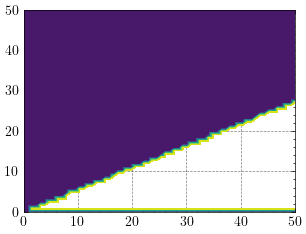

In [71]:
plt.tricontourf(coordinates[:,0], coordinates[:,1], u_initial)

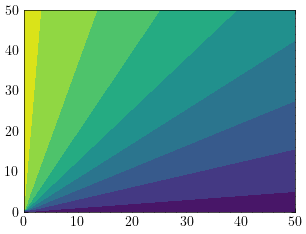

In [72]:
plt.tricontourf(coordinates[:,0], coordinates[:,1], v_initial)

In [73]:
@fem.LinearForm
def F_u(v,w):
    C1 = (1/dt)*(w.u_1 - w.u_0)*v
    C2 = (-1/(2*epsilon))*(w.u_1 - w.u_1**2 + w.u_0 - w.u_0**2)*v
    C3 = (f/(2*epsilon))*((w.v_1*((w.u_1 - q)/(w.u_1 + q))) + (w.v_0*((w.u_0 - q)/(w.u_0 + q))))*v
    C4 = (du/2)*(dot(grad(w.u_1), grad(v)) + dot(grad(w.u_0), grad(v)))
    return C1 + C2 + C3 + C4

@fem.LinearForm
def F_v(v,w):
    C1 = (1/dt)*(w.v_1 - w.v_0)*v
    C2 = (-1/2)*(w.u_1 + w.u_0)*v
    C3 = (1/2)*(w.v_1 + w.v_0)*v
    C4 = (dv/2)*((dot(grad(w.v_1), grad(v)) + dot(grad(w.v_0), grad(v))))
    return C1 + C2 + C3 + C4

u_previous = u_series[0,:]
v_previous = v_series[0,:]

def objective(uv_next):
    u_guess, v_guess = np.split(uv_next, 2)
    part_1 = F_u.assemble(basis, u_1 = basis.interpolate(u_guess), u_0 = basis.interpolate(u_previous), v_1 = basis.interpolate(v_guess), v_0 = basis.interpolate(v_previous))
    part_2 = F_v.assemble(basis, u_1 = basis.interpolate(u_guess), u_0 = basis.interpolate(u_previous), v_1 = basis.interpolate(v_guess), v_0 = basis.interpolate(v_previous))
    result = np.concatenate((part_1, part_2))
    print(np.sum(result**2))
    return result

def objective_scalar(uv_next):
    u_guess, v_guess = np.split(uv_next, 2)
    part_1 = F_u.assemble(basis, u_1 = basis.interpolate(u_guess), u_0 = basis.interpolate(u_previous), v_1 = basis.interpolate(v_guess), v_0 = basis.interpolate(v_previous))
    part_2 = F_v.assemble(basis, u_1 = basis.interpolate(u_guess), u_0 = basis.interpolate(u_previous), v_1 = basis.interpolate(v_guess), v_0 = basis.interpolate(v_previous))
    result = np.sum(np.concatenate((part_1, part_2))**2)
    print(result)
    return result

In [ ]:
result = scoptimize.root(objective, np.concatenate((u_previous, v_previous)), method='hybr')

22196.290743550217
22196.290743550217
22196.290743550217
22196.290743532685
22196.290743556303
22196.29074358356
22196.29074358563
22196.29074358669
22196.29074358738
22196.290743587855
22196.290743588208
22196.29074358848
22196.290743588695
22196.29074358887
22196.290743589016
22196.290743589136
22196.29074358924
22196.290743589332
22196.29074358941
22196.290743589478
22196.29074358954
22196.290743589594
22196.29074358964
22196.290743589685
22196.290743589725
22196.29074358976
22196.290743589798
22196.290743589827
22196.290743589856
22196.29074358988
22196.290743589907
22196.29074358993
22196.29074358995
22196.29074358997
22196.290743589987
22196.290743590005
22196.290743590023
22196.290743590038
22196.290743590052
22196.290743590067
22196.290743590078
22196.29074359009
22196.290743590103
22196.290743590114
22196.290743590125
22196.290743590132
22196.290743590143
22196.290743590154
22196.29074359016
22196.29074359017
22196.290743590176
22196.290743590187
22196.290743590194
22196.29074

In [59]:
result_scalar = scoptimize.minimize(objective_scalar, np.concatenate((u_previous, v_previous)), method='L-BFGS-B')

5694.59231099949
5694.592310723356
5694.592310886863
5694.5923112248975
5694.592311238754
5694.592311245875
5694.59231125047
5694.592311253679
5694.592311256049
5694.59231125787
5694.592311259314
5694.592311260486
5694.592311261457
5694.592311262275
5694.5923112629725
5694.5923112635755
5694.592311264101
5694.592311264563
5694.592311264973
5694.592311265339
5694.592311265669
5694.592311265966
5694.592311266236
5694.592311266481
5694.592311266706
5694.592311266913
5694.592311267104
5694.59231126728
5694.592311267444
5694.5923112675955
5694.592311267737
5694.59231126787
5694.592311267995
5694.592311268111
5694.592311268221
5694.592311268324
5694.592311268421
5694.592311268514
5694.592311268601
5694.592311268684
5694.592311268763
5694.592311268838
5694.592311268909
5694.592311268976
5694.592311269042
5694.592311269103
5694.592311269162
5694.592311269219
5694.592311269273
5694.592311269325
5694.5923112693745
5694.592311269423
5694.592311269469
5694.592311269513
5694.592311269556
5694.59231

KeyboardInterrupt: 

In [65]:
result.x

array([0.00429036, 0.00430431, 0.00483097, ..., 0.02094704, 0.02128352,
       0.02160901])

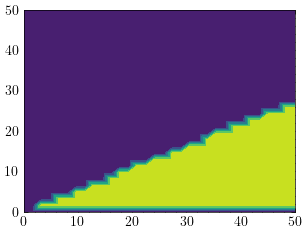

In [67]:
u_result, v_result = np.split(result.x, 2)

plt.tricontourf(coordinates[:,0], coordinates[:,1], u_result)

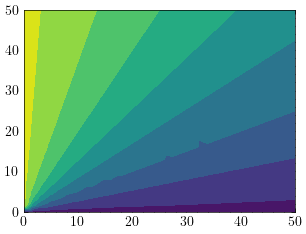

In [68]:
plt.tricontourf(coordinates[:,0], coordinates[:,1], v_result)